In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numba as nb
import pandas_ta as ta
import os
import datetime
import json
from tabulate import tabulate
import sys
sys.path.append('../..')
import vectorbtpro as vbt
from vectorbtpro.portfolio.enums import SizeType
from src.utils import fu
from src.utils import plot_return_mdd
from src.strategy.BackTester import BackTester
from src.strategy.Analyzer import Analyzer
from src.strategy.MultiTester import MultiTester
from src.utils import plot_return_mdd,twinx_plot # as utils
from kd_smoother_v0 import get_data,Strategy
# plt.style.use('seaborn')

In [2]:
df_dict = {}
candidate = ['SOL','ETH']#,'XRP','RUNE','INJ','ETC','GMT']
# ,'BTC','BNB','SOL','MATIC',
#                'XRP','DYDX','AVAX','LINK','GAS',
#                'DOGE','ORDI','TRB','WLD','ADA',
#                'OP','FIL','ZRX','LTC','RUNE','ATOM',
#                'ARB','GMT','ETC','ARK','BCH','DOT',
#                'LDO','SUI','GALA','CAKE',
#                'APE','INJ','FTM','APT','YFI','OMG',
#                'SEI','EOS','1000SHIB','NEAR',
#                'MKR','CYBER','UNI',
#                'BLUR','SUSHI','WAVES','MASK','MANA',
#                'EGLD','AAVE','NEO','FET','TRX','GRT','ALGO','STX','XLM']
for coin in candidate:
    df_dict[coin] = get_data(coin)

In [98]:
import ast
import hiplot as hip

_symbol = os.listdir('./opt2/1h/')
# pd.read_csv(f'./opt2/1h/{s}/both_record_df.csv').drop(columns='Unnamed: 0')

def insample_params_highland(coin:str,direction:str):
    params_df = pd.read_csv(f'./opt2/1h/{coin}/{direction}_record_df.csv').drop(columns=['Unnamed: 0'])
    params_df['params'] = params_df['params'].apply(ast.literal_eval)
    temp_df = params_df['params'].apply(pd.Series)
    df = pd.concat([params_df.drop(columns='params'), temp_df], axis=1)
    target = df[['window_k','window_d','Sharpe Ratio','Calmar Ratio','Win Rate [%]']]
    # data_for_hiplot = target.to_dict
    exp = hip.Experiment.from_dataframe(target)
    exp.display(force_full_width=False, width=400, height=100)
    
from tqdm.auto import tqdm
start = '2022-01-01'
sep = ''
end = ''

def outample_params_highland(coin,direction):
    outsample_record = []
    params_df = pd.read_csv(f'/Users/johnsonhsiao/DC_capital_intern/strategy_research/CTA_TEST/Crypto/kd_smoother/opt2/1h/{coin}/{direction}_record_df.csv')
    for idx , row in tqdm(params_df[:int(len(params_df)/5)].iterrows(), total=int(len(params_df)/5), desc="Processing"):
        params = eval(row['params'])
        # sol 1h : 40,48,100,126,95
        config = {'freq':'1h', 'lag':1, 'fee': 0.0003,'weekend_filter':False}
        df = df_dict[coin]
        strategy = Strategy(df=df.loc[start:], configs=config,)
        analyze = Analyzer(strategy)
        mdd, stat = analyze.outsample_result_gen(params, direction, coin, axv_index=['2023-05-01'])
        params['mdd'] = mdd
        params['sharpe'] = stat['Sharpe Ratio']
        params['calmar'] = stat['Calmar Ratio']
        params['win rate'] = stat['Win Rate [%]']
        outsample_record.append(params)
    exp = hip.Experiment.from_iterable(outsample_record)
    exp.display()

In [134]:
outample_params_highland('INJ','both')

Processing:   0%|          | 0/480 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

APY: 173.97 %
MDD: 18.84 %
MDD Duration 87 days 02:00:00
worst trade: -22.10 %
2023-12-05 11:00:00 ~ 2023-12-08 20:00:00
avg holding days: 5.18 days
--------------------------------------------
PF: 1.94
Sharpe Ratio: 2.12
Calmar Ratio: 6.00
Sortino Ratio: 3.19
Omega Ratio: 1.08
--------------------------------------------
Expectancy : 2.87 %
Total Time Exposure : 85.96 %
Total Trades: 119
Win Rate: 48.74 %
--------------------------------------------
PF * Win Rate: 0.947


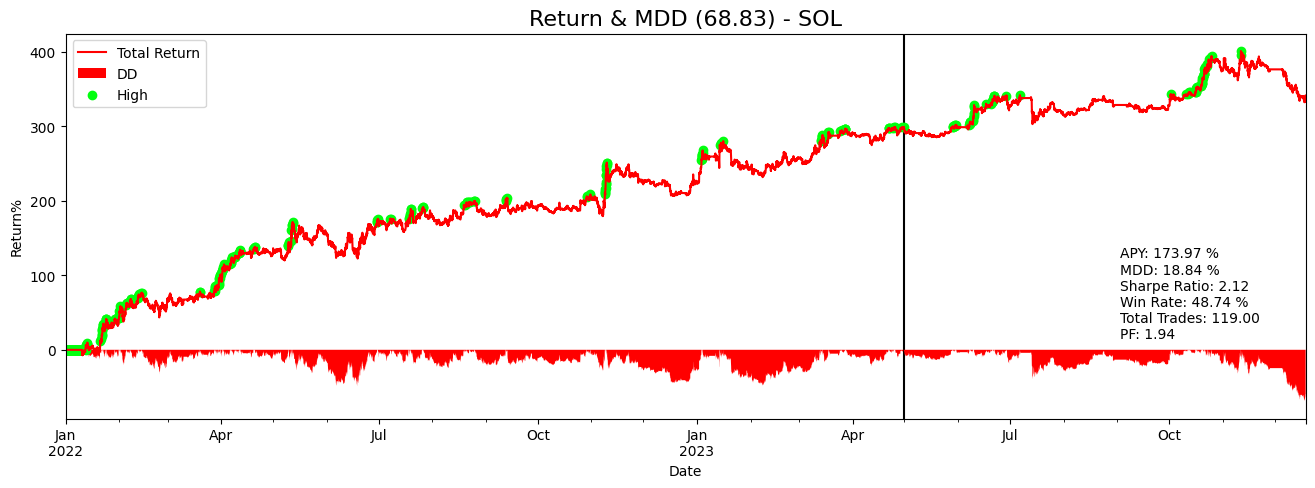

In [4]:
start = '2022-01-01'
sep = ''
end = ''

side = 'both'

params = {'window_k': 120, 'window_d': 96}

config = {'freq':'1h', 'lag':1, 'fee': 0.0003,'weekend_filter':False}
coin = 'SOL'

df = df_dict[coin]
strategy = Strategy(df=df.loc[start:], configs=config)
_pf = strategy.strategy(side = side,params=params)
trades = _pf.trades.records_readable
analyze = Analyzer(strategy)
# analyze.show_trades_analysis(trades)
# analyze.plot_ret_dist(trades)
value = analyze.show_pf_analysis(params, side, coin, axv_index=['2023-05-01'])

In [6]:
trades

,Exit Trade Id,Column,Size,Entry Order Id,Entry Index,Avg Entry Price,Entry Fees,Exit Order Id,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,69.879777,0,2022-01-10 04:00:00,143.060,2.9991,1,2022-01-17 09:00:00,143.590,3.010211,31.026970,0.003104,Long,Closed,0
1,1,0,72.406053,2,2022-01-17 21:00:00,138.110,3.0000,3,2022-01-26 09:00:00,95.780,2.080516,3059.867714,0.305987,Short,Closed,1
2,2,0,113.211819,4,2022-01-27 01:00:00,88.330,3.0000,5,2022-02-09 15:00:00,113.130,3.842296,2800.810823,0.280081,Long,Closed,2
3,3,0,90.155067,6,2022-02-10 03:00:00,110.920,3.0000,7,2022-02-16 01:00:00,103.120,2.789037,697.420483,0.069742,Short,Closed,3
4,4,0,99.970009,8,2022-02-16 18:00:00,100.030,3.0000,9,2022-02-19 18:00:00,90.230,2.706088,-985.412176,-0.098541,Long,Closed,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,112,0,215.280618,214,2023-11-09 15:00:00,46.451,3.0000,215,2023-11-14 09:00:00,54.269,3.504919,1676.558955,0.167656,Long,Closed,112
113,113,0,174.754906,216,2023-11-14 22:00:00,57.223,3.0000,217,2023-11-24 14:00:00,57.690,3.024483,-87.635024,-0.008764,Short,Closed,113
114,114,0,167.720511,218,2023-11-25 02:00:00,59.623,3.0000,219,2023-11-28 09:00:00,55.574,2.796270,-684.896617,-0.068490,Long,Closed,114
115,115,0,166.140555,220,2023-12-05 11:00:00,60.190,3.0000,221,2023-12-08 20:00:00,73.451,3.660957,-2209.850856,-0.220985,Short,Closed,115


### 多參數

======================= INJ L/S Optimize Test =======================

---------- INJ Long ----------
Optimization trails: 625


  0%|          | 0/625 [00:00<?, ?it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please

Optimization time: 30.86 sec
{'window_k': 28, 'window_d': 116}

---------- INJ Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:14<00:00, 42.63it/s]


Optimization time: 14.96 sec
{'window_k': 20, 'window_d': 132}
-------- INJ L/S --------
APY: 397.94 %
MDD: 27.58 %
-------------------------
Sharpe: 3.37
Calmar: 14.43
Sortino: 6.62
-------------------------


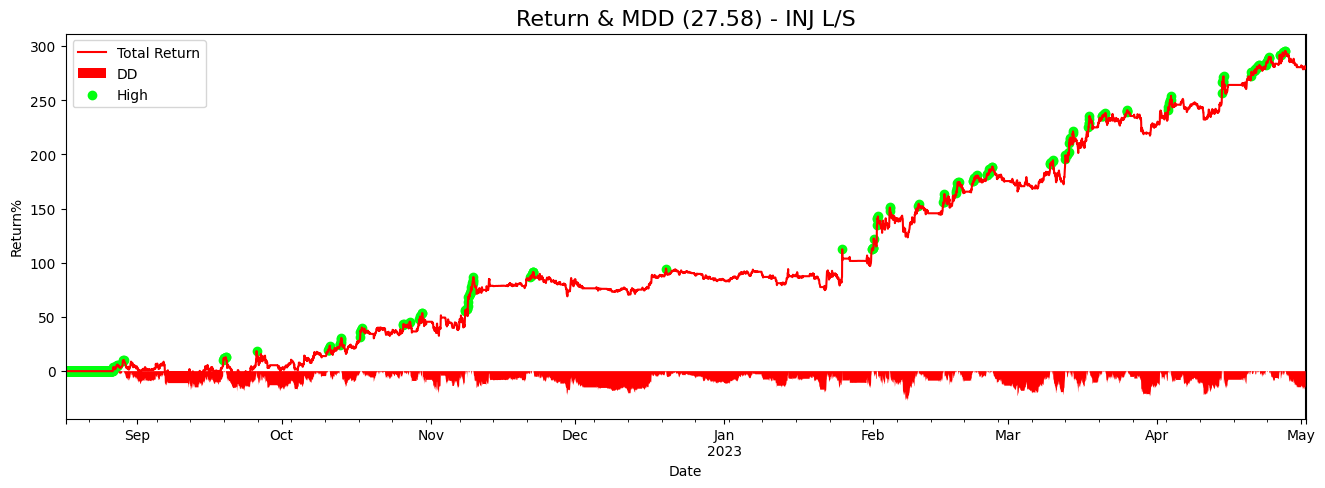

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-09    |      3.14 |  2315.28 | -2119.62 |       1.09 |   37.5  |          8 |
| 2022-12    |     92.07 | 13389.7  | -4414.54 |       3.03 |   56.67 |         30 |
| 2023-03    |    154.17 | 21320.6  | -5903.11 |       3.61 |   50    |         24 |
| 2023-06    |     34.31 |  5141.77 | -1710.46 |       3.01 |   40    |          5 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= TRB L/S Optimize Test =======================

---------- TRB Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:16<00:00, 37.66it/s]


Optimization time: 16.88 sec
{'window_k': 180, 'window_d': 4}

---------- TRB Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:15<00:00, 41.43it/s]


Optimization time: 15.33 sec
{'window_k': 20, 'window_d': 4}
-------- TRB L/S --------
APY: 294.84 %
MDD: 80.93 %
-------------------------
Sharpe: 2.26
Calmar: 3.64
Sortino: 3.98
-------------------------


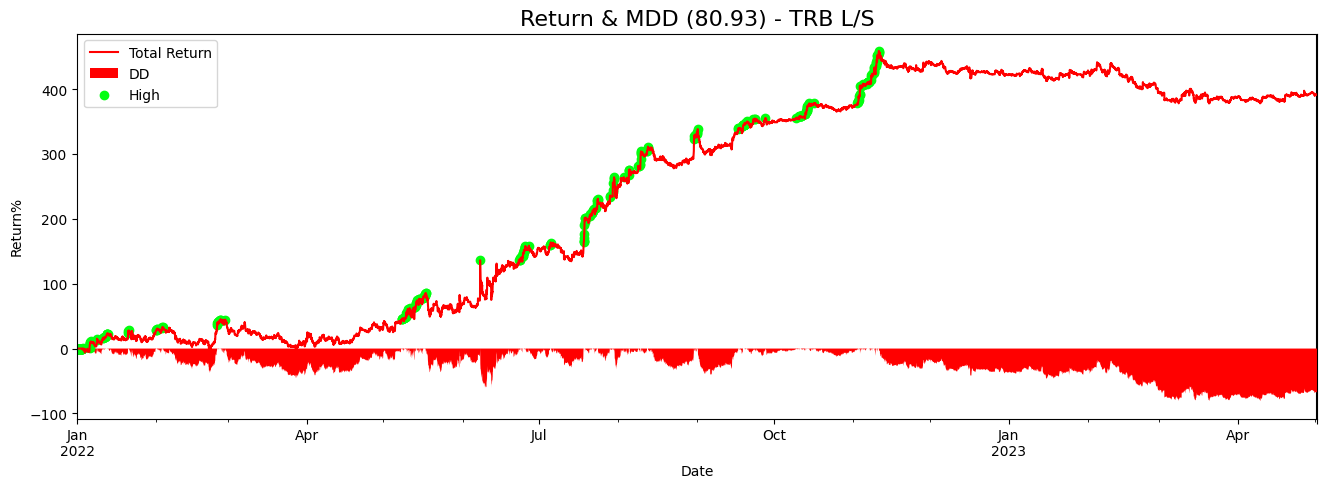

+------------+-----------+----------+-----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |      毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+-----------+------------+---------+------------|
| 2022-03    |     19.01 | 30513.7  | -29431.8  |       1.04 |   35.27 |        224 |
| 2022-06    |    152.95 | 46844.1  | -32522.4  |       1.44 |   42.29 |        227 |
| 2022-09    |    196.56 | 45295.5  | -25639.5  |       1.77 |   40.95 |        210 |
| 2022-12    |     71.66 | 24266.8  | -17101.2  |       1.42 |   45.37 |        227 |
| 2023-03    |    -34.28 | 22004    | -25431.8  |       0.87 |   37.19 |        242 |
| 2023-06    |      3.8  |  4830.41 |  -4450.85 |       1.09 |   36.59 |         82 |
+------------+-----------+----------+-----------+------------+---------+------------+
======================= FIL L/S Optimize Test =======================

---------- FIL Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:13<00:00, 46.71it/s]


Optimization time: 13.61 sec
{'window_k': 12, 'window_d': 180}

---------- FIL Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 49.80it/s]


Optimization time: 12.89 sec
{'window_k': 20, 'window_d': 108}
-------- FIL L/S --------
APY: 257.83 %
MDD: 74.45 %
-------------------------
Sharpe: 2.52
Calmar: 3.46
Sortino: 4.63
-------------------------


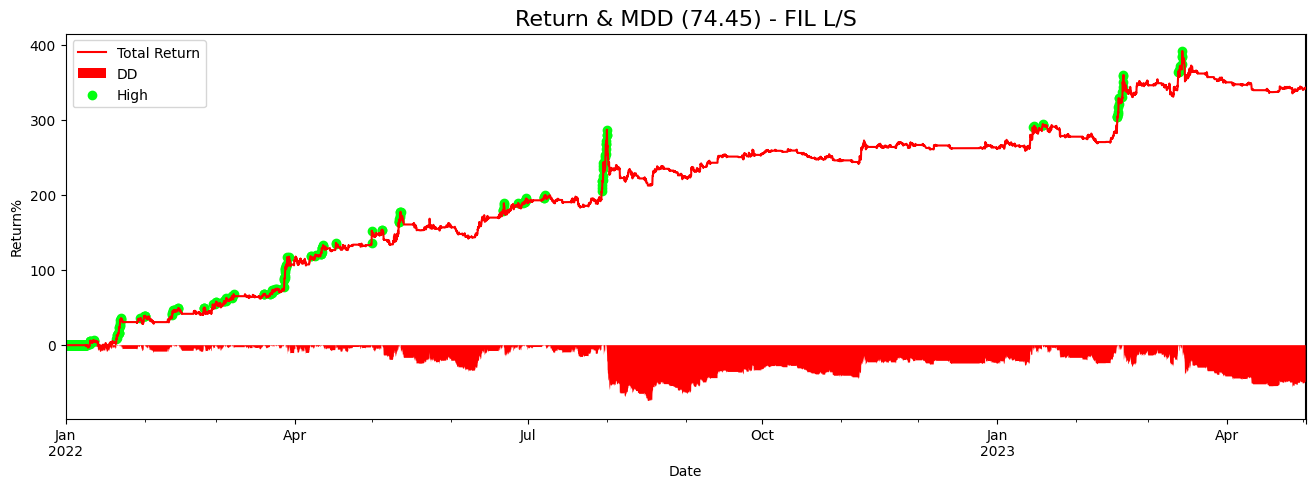

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    111.38 | 12871.7  | -2112.37 |       6.09 |   68.42 |         19 |
| 2022-06    |     85.49 | 13853.5  | -5304.82 |       2.61 |   52.94 |         34 |
| 2022-09    |     64.65 | 11522    | -5057.5  |       2.28 |   53.85 |         26 |
| 2022-12    |     12.95 |  5060.3  | -3764.84 |       1.34 |   35    |         40 |
| 2023-03    |     79.67 | 14851.4  | -6884.75 |       2.16 |   38.71 |         31 |
| 2023-06    |     -7.75 |  1454.27 | -2229.47 |       0.65 |   25    |          8 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= LTC L/S Optimize Test =======================

---------- LTC Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:13<00:00, 45.92it/s]


Optimization time: 13.9 sec
{'window_k': 4, 'window_d': 148}

---------- LTC Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:13<00:00, 47.65it/s]


Optimization time: 13.37 sec
{'window_k': 12, 'window_d': 92}
-------- LTC L/S --------
APY: 126.27 %
MDD: 41.44 %
-------------------------
Sharpe: 1.85
Calmar: 3.05
Sortino: 3.23
-------------------------


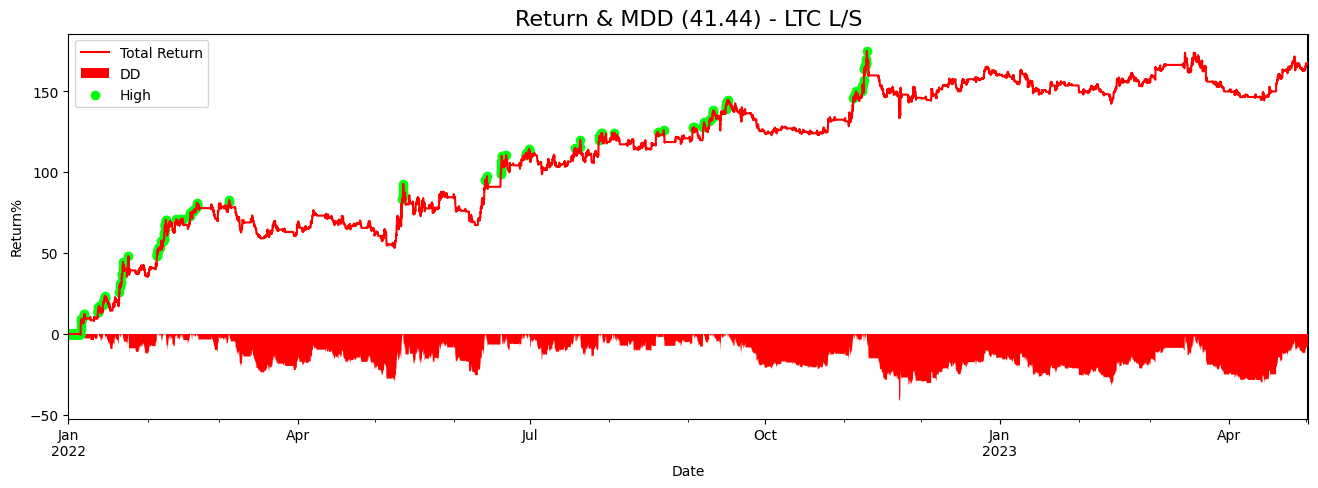

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |     63.89 | 11080.5  | -4692.03 |       2.36 |   44.12 |         34 |
| 2022-06    |     49.67 | 11474.3  | -6507.68 |       1.76 |   38.64 |         44 |
| 2022-09    |     10.43 |  8991.35 | -7948.76 |       1.13 |   35.09 |         57 |
| 2022-12    |     36.27 |  9517.39 | -5890.03 |       1.62 |   46    |         50 |
| 2023-03    |    -10.35 |  5398.51 | -6433.27 |       0.84 |   38.89 |         54 |
| 2023-06    |     17.88 |  2604.43 |  -816.54 |       3.19 |   53.85 |         13 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= ATOM L/S Optimize Test =======================

---------- ATOM Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:14<00:00, 43.29it/s]


Optimization time: 14.76 sec
{'window_k': 12, 'window_d': 124}

---------- ATOM Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:13<00:00, 45.51it/s]


Optimization time: 14.79 sec
{'window_k': 4, 'window_d': 84}
-------- ATOM L/S --------
APY: 215.82 %
MDD: 49.27 %
-------------------------
Sharpe: 2.76
Calmar: 4.38
Sortino: 4.75
-------------------------


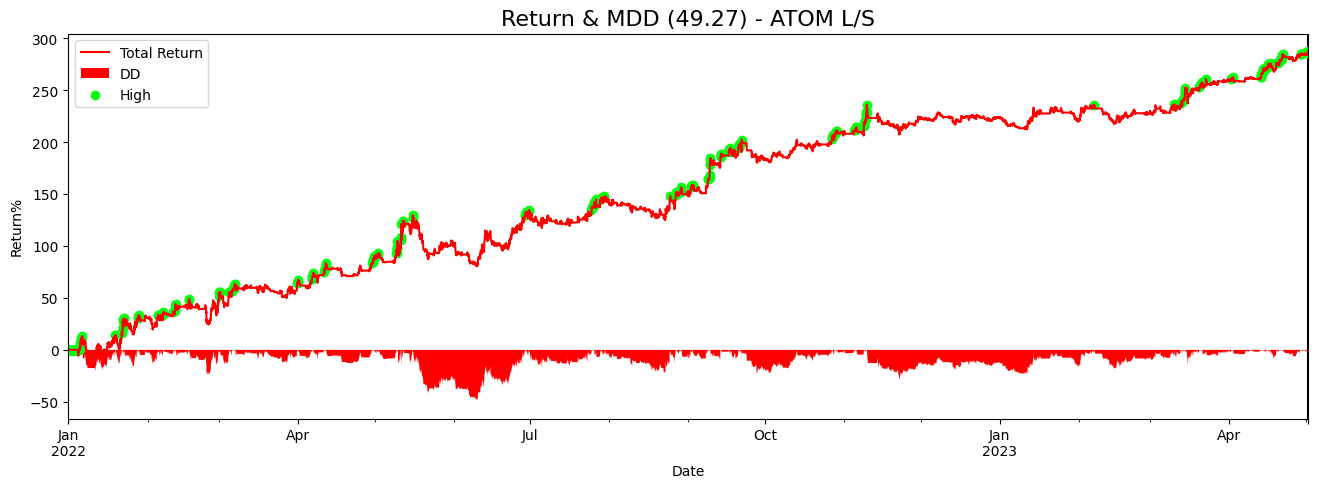

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |     62.1  | 14374.4  | -8290.35 |       1.73 |   50    |         40 |
| 2022-06    |     66.7  | 14890.5  | -8436.11 |       1.77 |   50    |         38 |
| 2022-09    |     57.82 | 14817.5  | -9060.6  |       1.64 |   44.07 |         59 |
| 2022-12    |     40.01 | 10175.4  | -6174.62 |       1.65 |   40.74 |         54 |
| 2023-03    |     35.98 |  8457.91 | -4859.88 |       1.74 |   40.48 |         42 |
| 2023-06    |     27.83 |  3198.7  |  -416.07 |       7.69 |   66.67 |          9 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= ETC L/S Optimize Test =======================

---------- ETC Long ----------
Optimization trails: 625


 58%|█████▊    | 360/625 [00:09<00:08, 30.71it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 67%|██████▋   | 416/625 [00:12<00:19, 10.73it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 69%|██████▉   | 432/625 [00:15<00:35,  5.42it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/si

Optimization time: 23.25 sec
{'window_k': 28, 'window_d': 84}

---------- ETC Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 50.94it/s]


Optimization time: 12.5 sec
{'window_k': 44, 'window_d': 84}
-------- ETC L/S --------
APY: 268.39 %
MDD: 50.13 %
-------------------------
Sharpe: 2.70
Calmar: 5.35
Sortino: 5.15
-------------------------


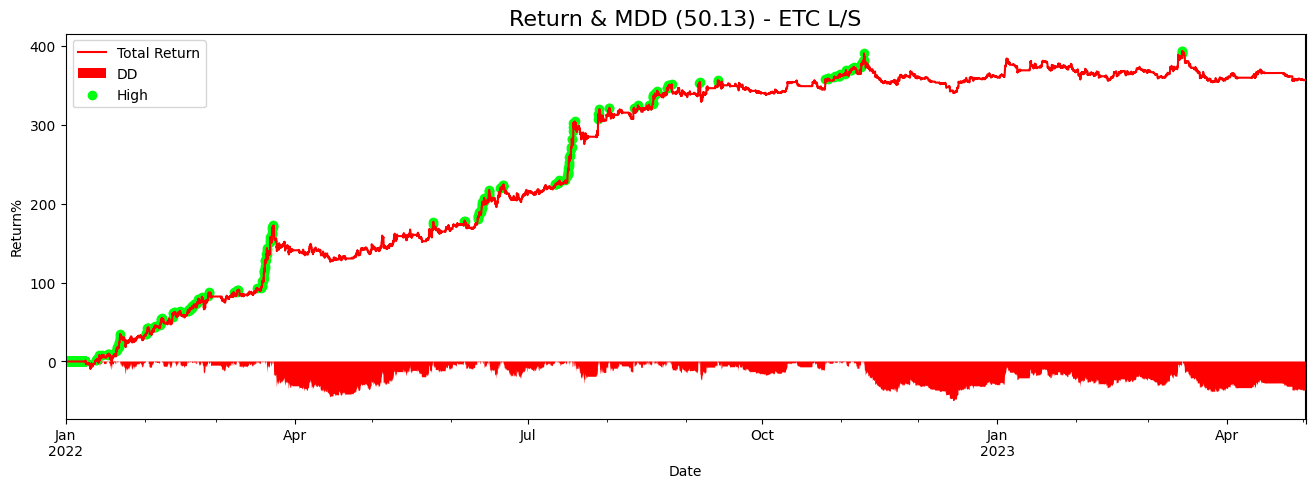

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    141.63 | 16603.8  | -2510.62 |       6.61 |   61.11 |         18 |
| 2022-06    |     72.33 | 11553.1  | -4320.59 |       2.67 |   50    |         26 |
| 2022-09    |    127.01 | 17450    | -4749.03 |       3.67 |   56    |         25 |
| 2022-12    |     35.8  |  9471.38 | -5891.42 |       1.61 |   46.43 |         28 |
| 2023-03    |    -14.94 |  5062.9  | -6556.47 |       0.77 |   36.67 |         30 |
| 2023-06    |     -4.51 |  1503.81 | -1954.56 |       0.77 |   37.5  |          8 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= WAVES L/S Optimize Test =======================

---------- WAVES Long ----------
Optimization trails: 625


 15%|█▌        | 96/625 [00:02<00:28, 18.51it/s] /Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 19%|█▉        | 120/625 [00:04<00:29, 17.00it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 28%|██▊       | 176/625 [00:07<00:32, 13.81it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/si

Optimization time: 19.9 sec
{'window_k': 116, 'window_d': 52}

---------- WAVES Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 48.98it/s]


Optimization time: 12.99 sec
{'window_k': 12, 'window_d': 76}
-------- WAVES L/S --------
APY: 426.28 %
MDD: 43.11 %
-------------------------
Sharpe: 3.24
Calmar: 9.89
Sortino: 6.65
-------------------------


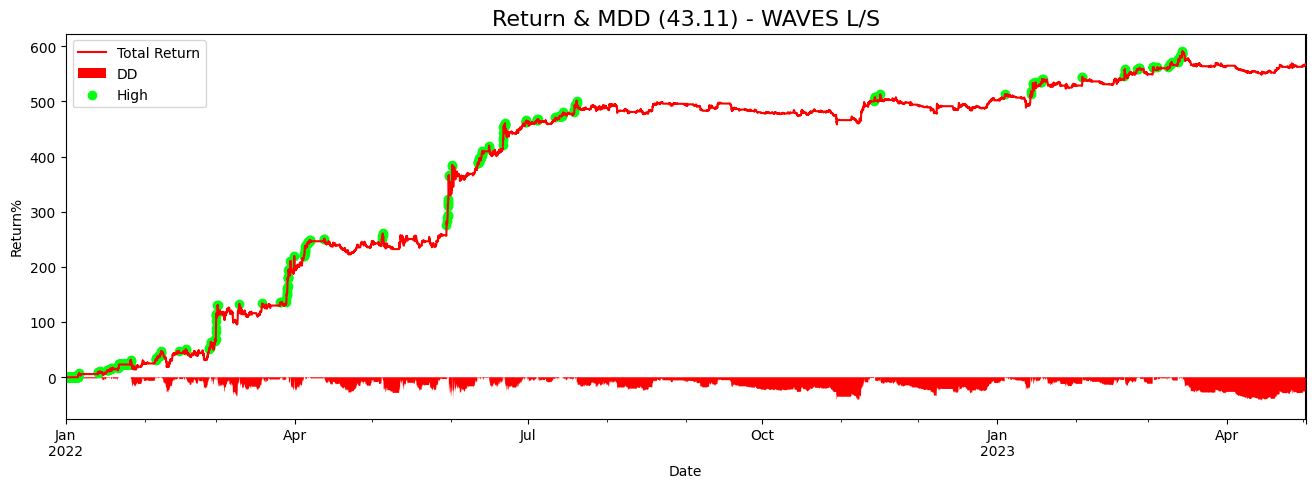

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    247.22 | 29047.2  | -4394.98 |       6.61 |   66.67 |         21 |
| 2022-06    |    212.99 | 29116.2  | -7816.95 |       3.72 |   56    |         25 |
| 2022-09    |     18.79 |  9621.99 | -7742.57 |       1.24 |   35.14 |         37 |
| 2022-12    |     23.71 |  9141.16 | -6769.82 |       1.35 |   37.84 |         37 |
| 2023-03    |     62.67 | 13946    | -7678.57 |       1.82 |   48.48 |         33 |
| 2023-06    |      1.73 |  1657.62 | -1484.39 |       1.12 |   54.55 |         11 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= AAVE L/S Optimize Test =======================

---------- AAVE Long ----------
Optimization trails: 625


 65%|██████▌   | 408/625 [00:08<00:05, 41.65it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 68%|██████▊   | 428/625 [00:11<00:17, 11.41it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 83%|████████▎ | 516/625 [00:15<00:04, 24.30it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/si

Optimization time: 21.79 sec
{'window_k': 60, 'window_d': 156}

---------- AAVE Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 48.14it/s]


Optimization time: 13.25 sec
{'window_k': 148, 'window_d': 132}
-------- AAVE L/S --------
APY: 239.27 %
MDD: 46.76 %
-------------------------
Sharpe: 2.50
Calmar: 5.12
Sortino: 3.88
-------------------------


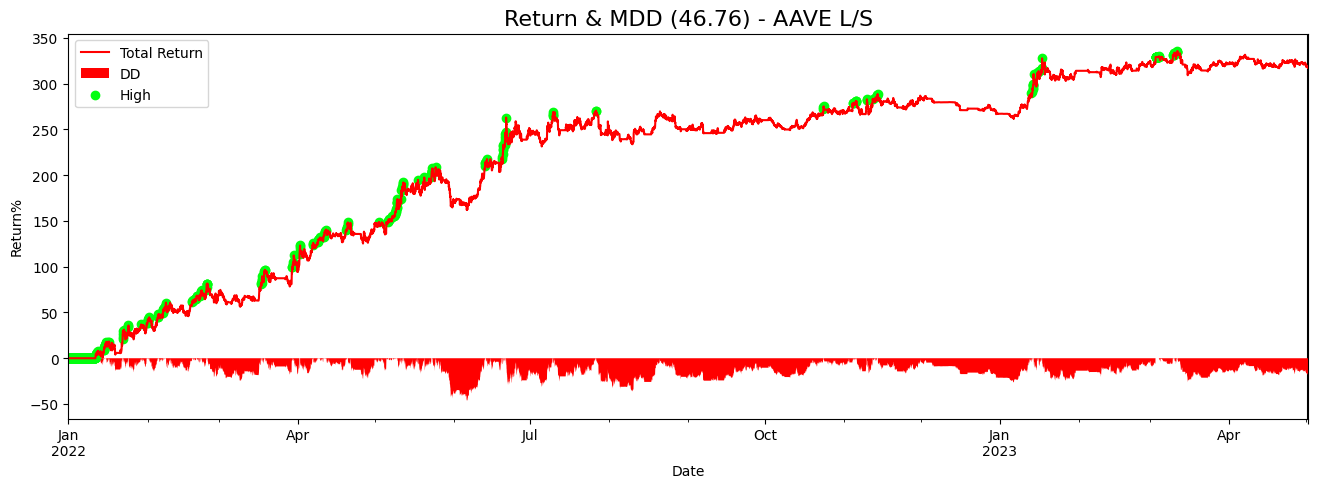

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    106.93 | 12919.3  | -2227.06 |       5.8  |   70    |         10 |
| 2022-06    |    132.05 | 15670    | -2465.4  |       6.36 |   70    |         10 |
| 2022-09    |     21.21 |  4635.94 | -2514.8  |       1.84 |   53.85 |         13 |
| 2022-12    |     52.65 |  9921.01 | -4655.85 |       2.13 |   46.67 |         15 |
| 2023-03    |     14.27 |  3892.92 | -2466.31 |       1.58 |   46.15 |         13 |
| 2023-06    |     -9.16 |   329.64 | -1245.58 |       0.26 |   25    |          4 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= GRT L/S Optimize Test =======================

---------- GRT Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 49.30it/s]


Optimization time: 12.97 sec
{'window_k': 52, 'window_d': 76}

---------- GRT Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:13<00:00, 46.91it/s]


Optimization time: 13.64 sec
{'window_k': 52, 'window_d': 44}
-------- GRT L/S --------
APY: 244.74 %
MDD: 65.04 %
-------------------------
Sharpe: 2.06
Calmar: 3.76
Sortino: 3.86
-------------------------


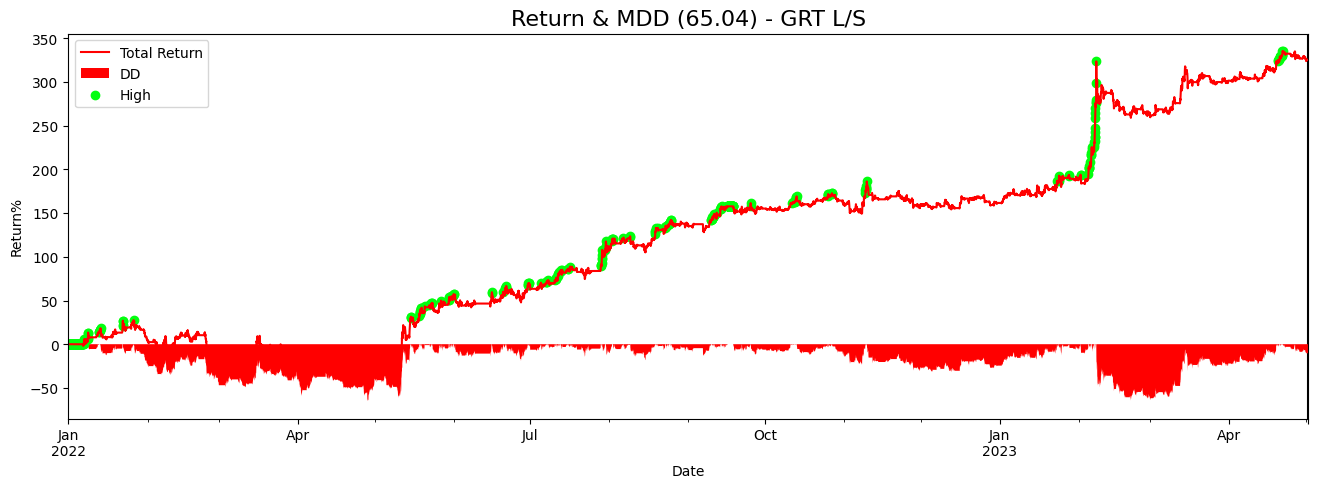

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    -22.3  |  7288.09 | -9801.92 |       0.74 |   37.04 |         27 |
| 2022-06    |     93.49 | 13502.5  | -4647.35 |       2.91 |   48    |         25 |
| 2022-09    |     95.92 | 13693.4  | -4512.6  |       3.03 |   62.5  |         24 |
| 2022-12    |      6.46 |  6799.46 | -6153.79 |       1.1  |   43.33 |         30 |
| 2023-03    |    141.8  | 20908.8  | -6728.92 |       3.11 |   53.33 |         30 |
| 2023-06    |     21.73 |  3870.68 | -1697.6  |       2.28 |   50    |         10 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= XLM L/S Optimize Test =======================

---------- XLM Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 50.06it/s]


Optimization time: 12.71 sec
{'window_k': 28, 'window_d': 68}

---------- XLM Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:12<00:00, 49.79it/s]


Optimization time: 12.94 sec
{'window_k': 124, 'window_d': 76}
-------- XLM L/S --------
APY: 131.71 %
MDD: 32.45 %
-------------------------
Sharpe: 2.33
Calmar: 4.06
Sortino: 3.56
-------------------------


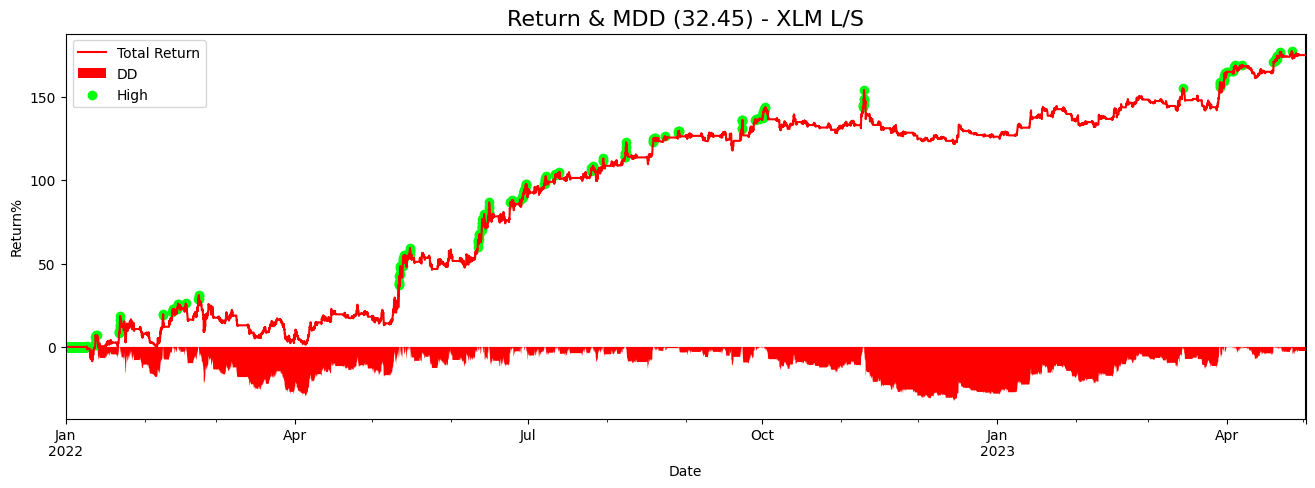

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |     25.37 |  9117.01 | -6920.82 |       1.32 |   39.13 |         23 |
| 2022-06    |     75.82 | 10949.4  | -3582.44 |       3.06 |   40.91 |         22 |
| 2022-09    |     40.91 |  6720.02 | -2629.41 |       2.56 |   61.9  |         21 |
| 2022-12    |     -9.65 |  3463.06 | -4427.98 |       0.78 |   32.14 |         28 |
| 2023-03    |     38.06 |  6671.35 | -2865.06 |       2.33 |   52    |         25 |
| 2023-06    |     10.05 |  1399.51 |  -394.04 |       3.55 |   42.86 |          7 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= GMT L/S Optimize Test =======================

---------- GMT Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:14<00:00, 43.08it/s]


Optimization time: 15.38 sec
{'window_k': 164, 'window_d': 44}

---------- GMT Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:14<00:00, 42.75it/s]


Optimization time: 14.87 sec
{'window_k': 140, 'window_d': 52}
-------- GMT L/S --------
APY: 449.67 %
MDD: 80.89 %
-------------------------
Sharpe: 2.93
Calmar: 5.56
Sortino: 5.49
-------------------------


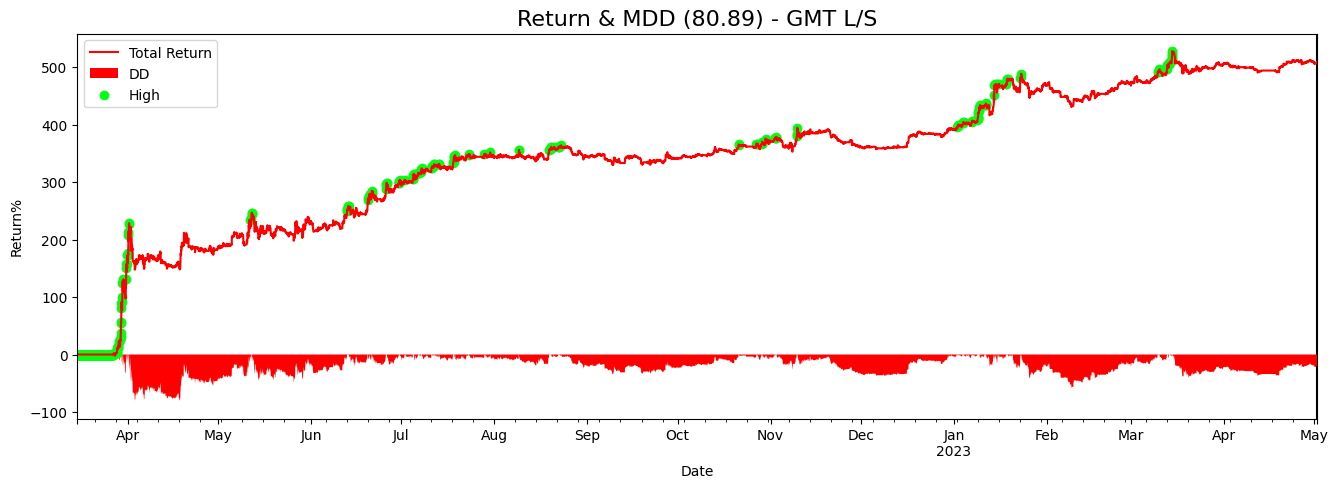

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    162.04 | 16203.5  |     0    |     inf    |  100    |          2 |
| 2022-06    |    139.59 | 19827.9  | -6140.93 |       3.23 |   50    |         22 |
| 2022-09    |     45.25 |  8799.75 | -4274.8  |       2.06 |   52.63 |         19 |
| 2022-12    |     46.81 |  9655.05 | -4974.48 |       1.94 |   36.36 |         22 |
| 2023-03    |    108.84 | 18812.2  | -7928.17 |       2.37 |   63.64 |         22 |
| 2023-06    |      7.77 |  1612.86 |  -836    |       1.93 |   28.57 |          7 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= MKR L/S Optimize Test =======================

---------- MKR Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:15<00:00, 41.26it/s]


Optimization time: 15.45 sec
{'window_k': 76, 'window_d': 36}

---------- MKR Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:13<00:00, 46.18it/s]


Optimization time: 14.44 sec
{'window_k': 36, 'window_d': 68}
-------- MKR L/S --------
APY: 155.47 %
MDD: 61.41 %
-------------------------
Sharpe: 1.93
Calmar: 2.53
Sortino: 3.10
-------------------------


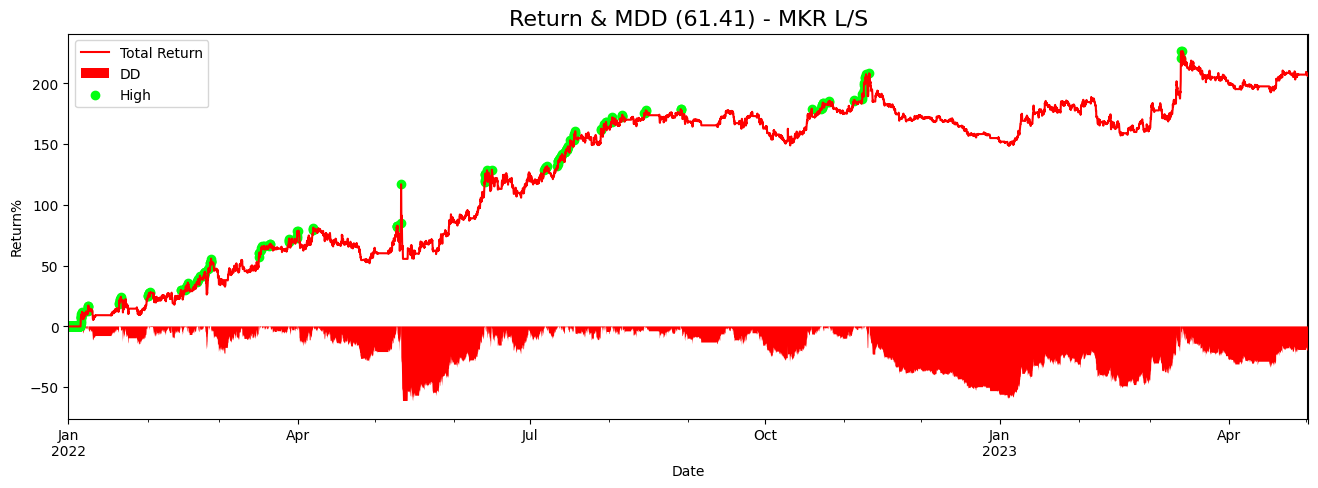

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |     69.07 | 11229.7  | -4522.57 |       2.48 |   60.87 |         23 |
| 2022-06    |     53.71 | 13207.1  | -7888.35 |       1.67 |   55.17 |         29 |
| 2022-09    |     38.73 |  8931.4  | -5058.76 |       1.77 |   44    |         25 |
| 2022-12    |     -6.95 |  6765.35 | -7460.28 |       0.91 |   38.24 |         34 |
| 2023-03    |     47.01 | 10463.6  | -5762.86 |       1.82 |   33.33 |         30 |
| 2023-06    |      7.54 |  1811.41 | -1057    |       1.71 |   40    |         10 |
+------------+-----------+----------+----------+------------+---------+------------+
======================= NEO L/S Optimize Test =======================

---------- NEO Long ----------
Optimization trails: 625


100%|██████████| 625/625 [00:14<00:00, 43.56it/s]


Optimization time: 14.68 sec
{'window_k': 28, 'window_d': 4}

---------- NEO Short ----------
Optimization trails: 625


100%|██████████| 625/625 [00:14<00:00, 41.97it/s]


Optimization time: 15.73 sec
{'window_k': 36, 'window_d': 4}
-------- NEO L/S --------
APY: 156.21 %
MDD: 48.24 %
-------------------------
Sharpe: 1.93
Calmar: 3.24
Sortino: 3.54
-------------------------


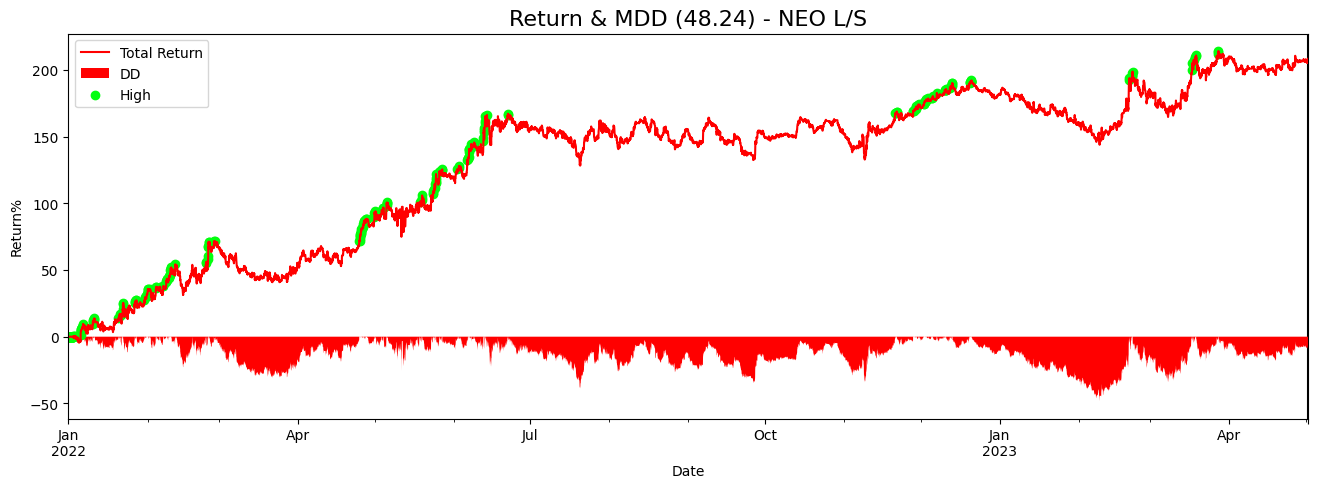

+------------+-----------+----------+-----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |      毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+-----------+------------+---------+------------|
| 2022-03    |     54.14 | 27427.4  | -22146.9  |       1.24 |   42.49 |        233 |
| 2022-06    |    103.37 | 33125.1  | -22788.4  |       1.45 |   49.78 |        223 |
| 2022-09    |     -6.84 | 22348.8  | -23032.9  |       0.97 |   38.33 |        240 |
| 2022-12    |     32.33 | 17154.3  | -13921.3  |       1.23 |   38.2  |        233 |
| 2023-03    |     27.22 | 25369.1  | -22647.4  |       1.12 |   40.6  |        234 |
| 2023-06    |     -1.32 |  4865.18 |  -4997.02 |       0.97 |   38.82 |         85 |
+------------+-----------+----------+-----------+------------+---------+------------+
======================= 1000SHIB L/S Optimize Test =======================

---------- 1000SHIB Long ----------
Optimization trails: 625


  7%|▋         | 44/625 [00:02<00:21, 27.61it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 37%|███▋      | 232/625 [00:09<00:26, 14.99it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
 40%|███▉      | 248/625 [00:12<00:40,  9.34it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/sit

Optimization time: 24.62 sec
{'window_k': 60, 'window_d': 140}

---------- 1000SHIB Short ----------
Optimization trails: 625


 67%|██████▋   | 416/625 [00:08<00:07, 28.51it/s]/Users/johnsonhsiao/.pyenv/versions/3.10.13/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
100%|██████████| 625/625 [00:13<00:00, 44.81it/s]


Optimization time: 14.24 sec
{'window_k': 20, 'window_d': 12}
-------- 1000SHIB L/S --------
APY: 235.59 %
MDD: 41.10 %
-------------------------
Sharpe: 2.95
Calmar: 5.73
Sortino: 6.81
-------------------------


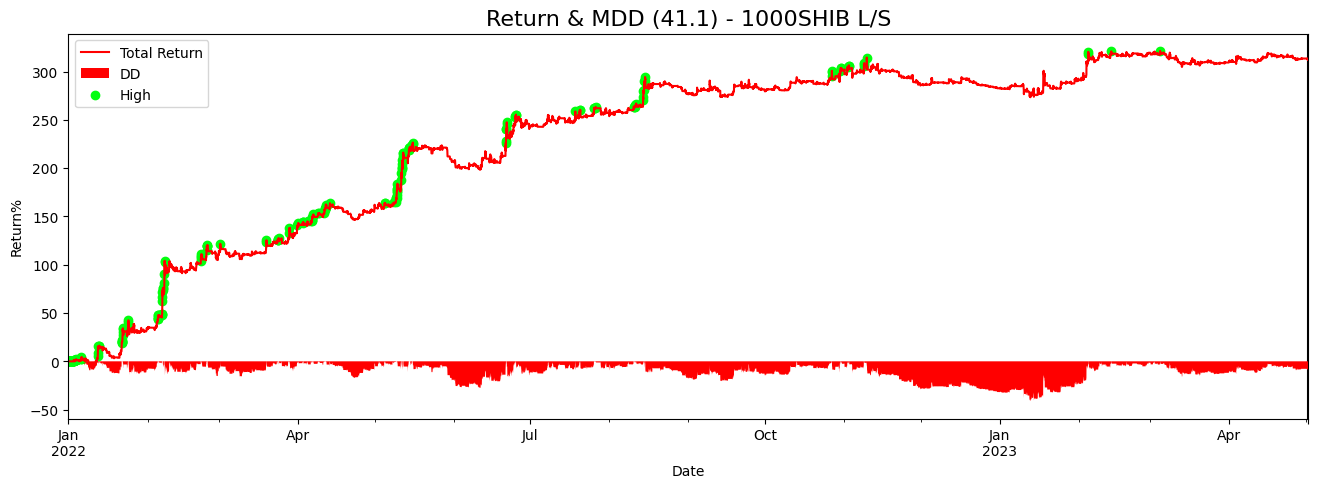

+------------+-----------+----------+----------+------------+---------+------------+
| datetime   |   收益率% |     毛利 |     毛損 |   獲利因子 |   勝率% |   交易次數 |
|------------+-----------+----------+----------+------------+---------+------------|
| 2022-03    |    141.52 | 18093.9  | -3972.27 |       4.56 |   56.36 |         55 |
| 2022-06    |    102.77 | 18044.3  | -7767.28 |       2.32 |   52.24 |         67 |
| 2022-09    |     37.65 | 11560.8  | -7796.32 |       1.48 |   48.44 |         64 |
| 2022-12    |      1.09 |  7077.32 | -6968.07 |       1.02 |   39.39 |         66 |
| 2023-03    |     29.35 | 10946.8  | -8011.42 |       1.37 |   46.97 |         66 |
| 2023-06    |      0.96 |  1644.17 | -1547.85 |       1.06 |   50    |         22 |
+------------+-----------+----------+----------+------------+---------+------------+


In [82]:
import warnings
warnings.filterwarnings("ignore")

start= '2022-01-01'
end ='2023-05-01'

symbol_list =  ['INJ','TRB','FIL','LTC','ATOM','ETC','WAVES','AAVE','GRT','XLM','GMT','MKR','NEO','1000SHIB']
sample_sets = [[start,end]]
freq = '1h'
config = {'freq':freq,'fee': 0.0003,'weekend_filter':False}

params = {'window_k': [4,200,8], 
          'window_d': [4,200,8]}


multi_test = MultiTester(
    Strategy,
    get_data_func=get_data,
    params=params,
    df_dict=df_dict,
    config=config,
    symbol_list=symbol_list,
    save_path='./opt2/',
    start=start,
    end=end
    )

all_params = multi_test.multi_params(symbol_list,sample_sets,direction='L/S')
trades, value_df = multi_test.multi_params_result(all_params)